#### This notebook takes in model features and scales it in a suitable way for our ML model

In [86]:
import pandas as pd
import numpy as np 

df = pd.read_parquet("../data/processed/model_features.parquet")
df.sample(5)

,last_purchase_date,purchase_recency,transaction_count,quantity,payment_method_count,promo_usage_count,customer_tenure,total_spent,future_spend
23484,2021-10-09 23:13:00,83.032510,2,3,1,1,233.025033,47.261,25.504
18145,2021-12-26 23:47:00,5.008587,9,16,1,6,355.436156,816.437,85.881
24157,2021-07-27 19:24:00,157.191160,1,1,1,1,157.191160,11.726,0.000
22041,2021-11-15 18:44:00,46.218924,4,12,2,0,298.391436,335.599,77.112
26817,2021-06-19 18:40:00,195.222110,1,15,1,0,195.222110,407.295,19.993


__Let's visualize customer tenure distribution since we just added it as a model feature__

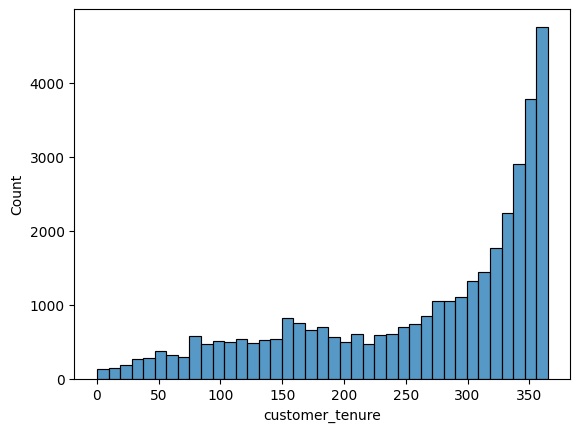

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df["customer_tenure"])
plt.show()

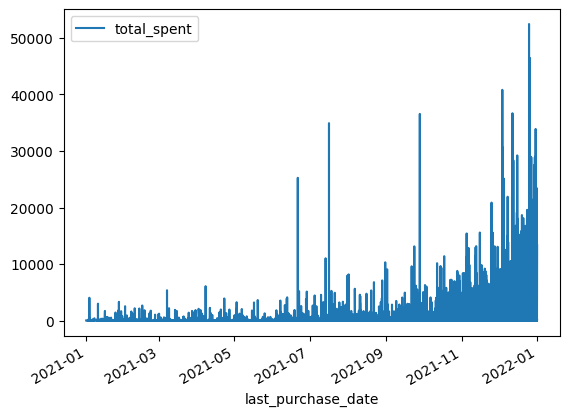

In [88]:
df.plot(x="last_purchase_date", y="total_spent")
plt.show()

__We will sort the dataframe by the customer's last purchase date since the data is based off of purchase time and different customers' purchase patterns may change over time and seasons. e.g transactions during summer may be different from those during the December holidays__

In [89]:
df = df.sort_values(by="last_purchase_date").reset_index(drop=True)
df

,last_purchase_date,purchase_recency,transaction_count,quantity,payment_method_count,promo_usage_count,customer_tenure,total_spent,future_spend
0,2021-01-01 01:14:00,364.948454,1,4,1,1,364.948454,58.543,0.000
1,2021-01-01 09:21:00,364.610004,1,2,1,2,364.610004,74.030,0.000
2,2021-01-01 16:04:00,364.330234,1,1,1,0,364.330234,4.094,0.000
3,2021-01-02 01:37:00,363.932382,1,1,1,0,363.932382,14.923,0.000
4,2021-01-02 09:29:00,363.604602,1,2,1,0,363.604602,35.029,0.000
...,...,...,...,...,...,...,...,...,...
36081,2021-12-31 23:53:00,0.004461,39,116,3,19,360.318883,7082.052,500.983
36082,2021-12-31 23:54:00,0.004067,17,43,3,7,102.036880,2084.390,998.193
36083,2021-12-31 23:54:00,0.003747,118,239,5,37,363.121734,13513.165,1866.608
36084,2021-12-31 23:56:00,0.002516,20,34,4,5,137.941532,502.177,760.096


In [90]:
log_features = ["transaction_count", "quantity", 
                "total_spent", "customer_tenure", "purchase_recency"]     
# these features a really right-skewed (from EDA notebook) so we log it to normalize its distribution

scale_features = ["payment_method_count", "promo_usage_count"]

# future_spend (the target) is not included

__We'll be setting up transformers inside a pipeline instead of doing it openly (helps avoid possible data leakage)__

In [91]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



# Applies np.log1p() to each feature to deal with outliers, then performs standard scaler on the logged values to keep variation between 0 and 1 still.
log_transformer = Pipeline(steps=[
    ("log", FunctionTransformer(np.log1p)),     # performs log only on the features that require it
    ("scaler", StandardScaler())
])

scale_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())    # Only scales particular features, ones that don't need logging 
])


In [92]:
preprocessor = ColumnTransformer(
    transformers=[
        ("log_features", log_transformer, log_features),
        ("scale_features", scale_transformer, scale_features),
    ]
)
preprocessor

ColumnTransformer(transformers=[('log_features',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('scaler', StandardScaler())]),
                                 ['transaction_count', 'quantity',
                                  'total_spent', 'customer_tenure',
                                  'purchase_recency']),
                                ('scale_features',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['payment_method_count',
                                  'promo_usage_count'])])

### Seperating features from target variable

In [93]:
X = df.drop(columns=["future_spend", "last_purchase_date"])
y = df["future_spend"]

In [94]:
X.sample(5)

,purchase_recency,transaction_count,quantity,payment_method_count,promo_usage_count,customer_tenure,total_spent
35793,0.340839,5,13,2,1,144.625503,417.691
17973,37.455882,3,5,2,1,289.815847,75.098
28080,11.019169,10,20,3,5,344.349157,476.057
11578,75.146508,1,1,1,0,75.146508,14.182
8492,108.267636,3,6,1,0,328.332890,39.009


In [95]:
y.sample(5)

12466      7.073
18838      8.051
17387    264.437
24482    297.766
27581     30.048
Name: future_spend, dtype: float64

#### <h3 style = "text-align:center;"> Splitting the data (Time Series Split) </h3>

__TimeSeriesSplit is used because it maintains the date order and gives multiple train-test folds. <br/> We'll be using the walk-forward cross-validation technique to evaluate on different train-test folds__



In [96]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

xgb = XGBRegressor(
    random_state=42,
    n_jobs=4, 
    objective='reg:tweedie',  # good for skewed data and handles many 0s being present
    tweedie_variance_power=1.9
    )

# pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", xgb)])
time_series_split = TimeSeriesSplit(n_splits=6)

In [102]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# We'll collect metrics for each fold and average it to get the overall performance
mae_scores = []
rmse_scores = []
fold_stats = []

for fold, (train_index, valid_index) in enumerate(time_series_split.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor), # our preprocessor pipeline (log and scaling)
        ("model", xgb)])    # data is now fitten into our xgboost model

    pipeline.fit(X_train, y_train)  # pipeline fit only on training data

    # Runs prediction on the validation set
    preds = pipeline.predict(X_valid)

    mae  = mean_absolute_error(y_valid, preds)
    rmse = root_mean_squared_error(y_valid, preds)

    mae_scores.append(mae)
    rmse_scores.append(rmse)

    # Collect descriptive stats for validation set
    valid_stats = {
        'fold': fold,
        'count': y_valid.count(),
        'mean': y_valid.mean(),
        'median': y_valid.median(),
        'std': y_valid.std(),
        'min': y_valid.min(),
        'max': y_valid.max(),
        'q25': y_valid.quantile(0.25),
        'q75': y_valid.quantile(0.75),
        'mae': mae,
        'rmse': rmse
    }
    fold_stats.append(valid_stats)

    print("=======================================")
    print(f"Fold {fold}")
    print(f"Train period: {X_train.index.min()} → {X_train.index.max()}")
    print(f"Valid period: {X_valid.index.min()} → {X_valid.index.max()}\n")
    print("Validation Set Statistics:")
    print(f"  Count: {y_valid.count()}")
    print(f"  Mean: {y_valid.mean():.2f}")
    print(f"  Median: {y_valid.median():.2f}")
    print(f"  Std Dev: {y_valid.std():.2f}")
    print(f"  Min: {y_valid.min():.2f}")
    print(f"  Max: {y_valid.max():.2f}")
    print(f"  Q1 (25%): {y_valid.quantile(0.25):.2f}")
    print(f"  Q3 (75%): {y_valid.quantile(0.75):.2f}\n")
    print(f"MAE for fold: {mae:.2f}")
    print(f"RMSE for fold: {rmse:.2f}")


print("\n" + "="*40)
print("Average performance")
print("="*40)
print(f"Average MAE across all folds : {np.mean(mae_scores):.2f}")
print(f"Average RMSE across all folds: {np.mean(rmse_scores):.2f}")

# Create a summary dataframe
stats_df = pd.DataFrame(fold_stats)
print("\nDetailed Stats by Fold:")
print(stats_df.to_string())

Fold 0
Train period: 0 → 5155
Valid period: 5156 → 10310

Validation Set Statistics:
  Count: 5155
  Mean: 23.26
  Median: 9.12
  Std Dev: 48.62
  Min: 0.00
  Max: 774.01
  Q1 (25%): 0.00
  Q3 (75%): 25.06

MAE for fold: 19.98
RMSE for fold: 50.32
Fold 1
Train period: 0 → 10310
Valid period: 10311 → 15465

Validation Set Statistics:
  Count: 5155
  Mean: 49.20
  Median: 26.19
  Std Dev: 72.22
  Min: 0.00
  Max: 939.76
  Q1 (25%): 0.00
  Q3 (75%): 61.99

MAE for fold: 43.11
RMSE for fold: 76.10
Fold 2
Train period: 0 → 15465
Valid period: 15466 → 20620

Validation Set Statistics:
  Count: 5155
  Mean: 84.42
  Median: 52.65
  Std Dev: 102.14
  Min: 0.00
  Max: 1308.59
  Q1 (25%): 14.40
  Q3 (75%): 115.63

MAE for fold: 52.15
RMSE for fold: 87.74
Fold 3
Train period: 0 → 20620
Valid period: 20621 → 25775

Validation Set Statistics:
  Count: 5155
  Mean: 150.71
  Median: 108.08
  Std Dev: 153.05
  Min: 0.00
  Max: 1414.49
  Q1 (25%): 38.37
  Q3 (75%): 214.55

MAE for fold: 74.24
RMSE for f

You can check out future spend over time but visualized, it shows the trend the model is working with:

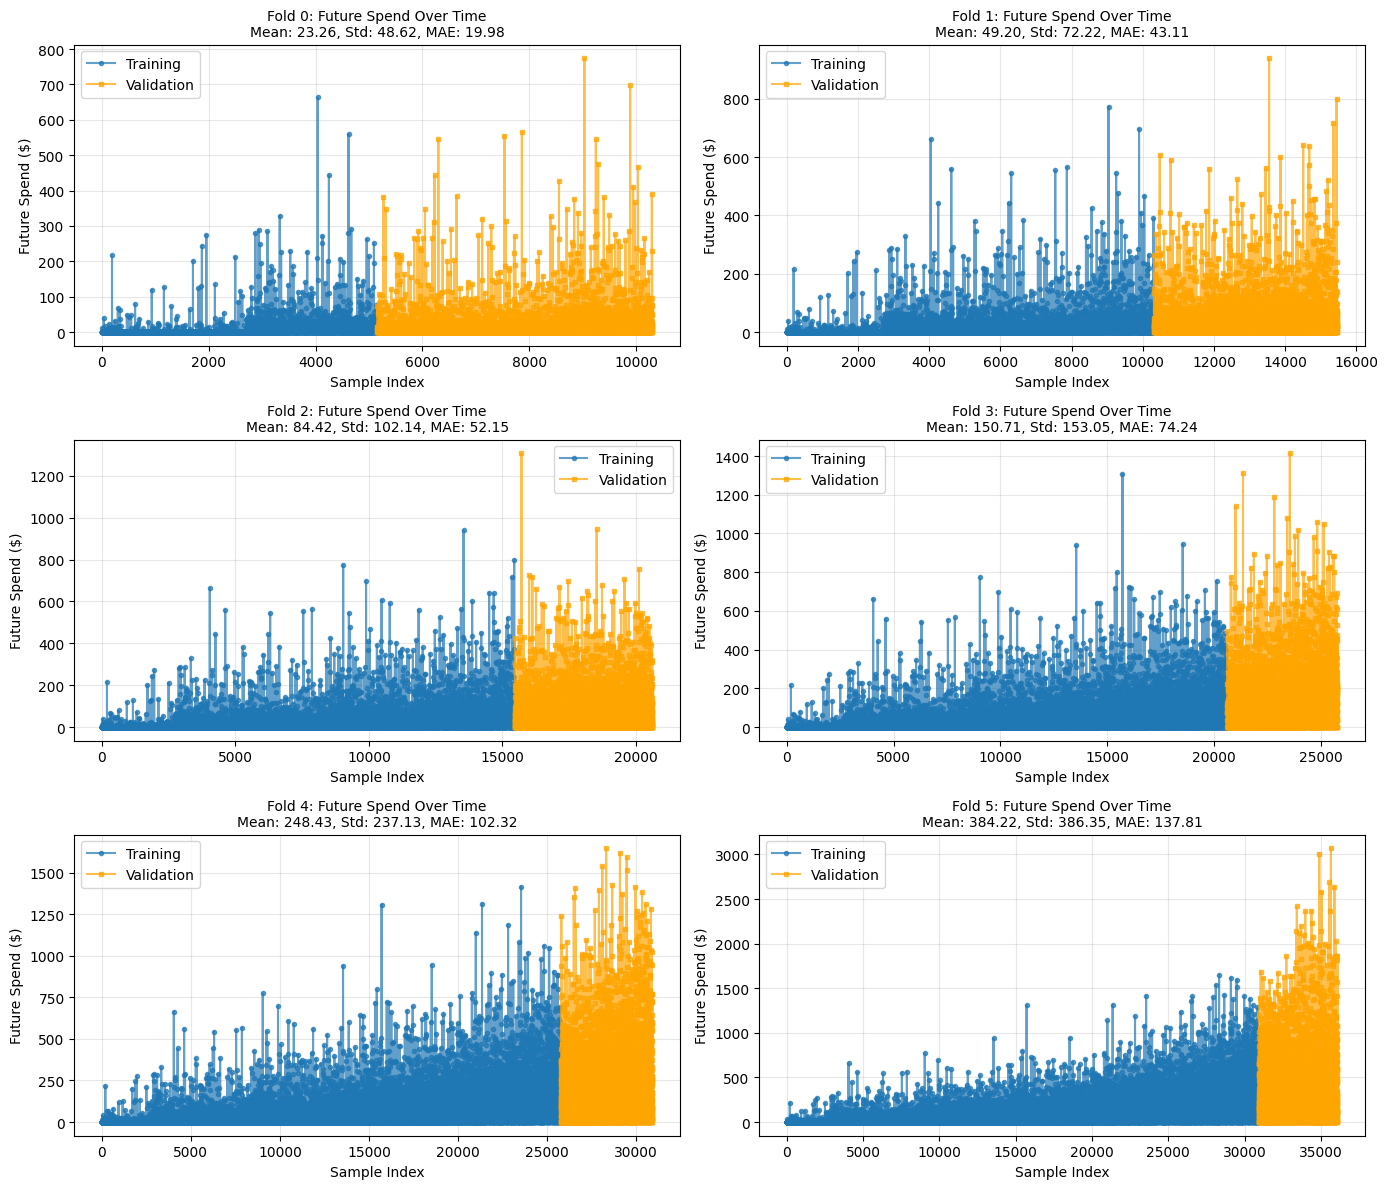

In [98]:
# Visualize future spend over time for each fold
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for fold, (train_index, valid_index) in enumerate(time_series_split.split(X)):
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    ax = axes[fold]
    
    # Plot training and validation data
    ax.plot(y_train.index, y_train.values, label='Training', alpha=0.7, marker='o', markersize=3)
    ax.plot(y_valid.index, y_valid.values, label='Validation', alpha=0.7, marker='s', markersize=3, color='orange')
    
    ax.set_title(f'Fold {fold}: Future Spend Over Time\nMean: {y_valid.mean():.2f}, Std: {y_valid.std():.2f}, MAE: {fold_stats[fold]["mae"]:.2f}', fontsize=10)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Future Spend ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

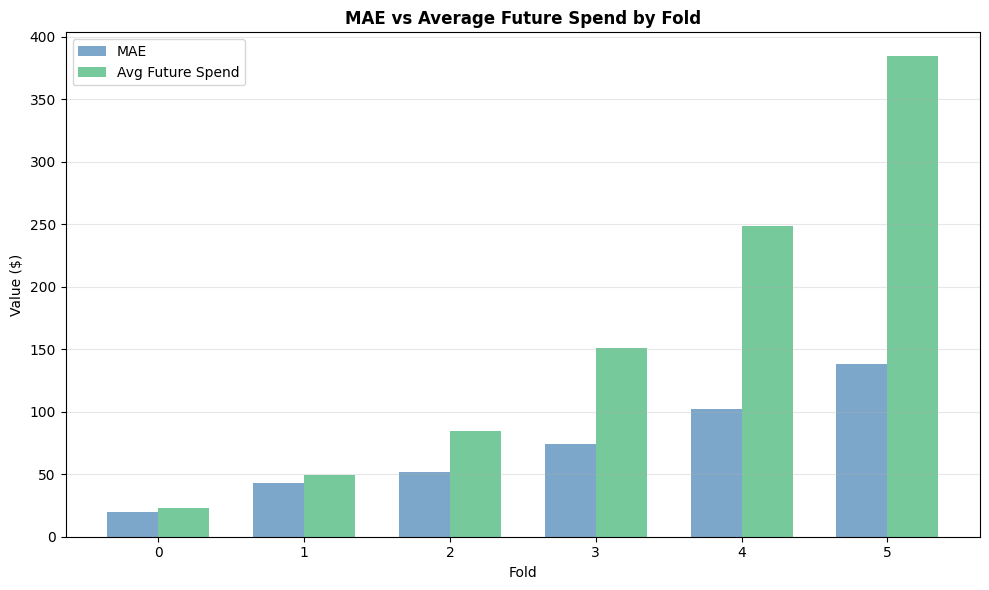

In [99]:
# Comparative analysis: Average Future Spend vs MAE per fold
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(stats_df['fold']))
width = 0.35

ax.bar(x - width/2, stats_df['mae'], width, label='MAE', color='steelblue', alpha=0.7)
ax.bar(x + width/2, stats_df['mean'], width, label='Avg Future Spend', color='mediumseagreen', alpha=0.7)

ax.set_title('MAE vs Average Future Spend by Fold', fontsize=12, fontweight='bold')
ax.set_xlabel('Fold')
ax.set_ylabel('Value ($)')
ax.set_xticks(x)
ax.set_xticklabels(stats_df['fold'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


__From the image above:__
+ Fold 0: MAE (19.9) / Mean (23.2) = 86% Error Ratio
+ Fold 2: MAE (52.1) / Mean (84.4) = 61% Error Ratio
+ Fold 5: MAE (137.8) / Mean (384.2) = 35% Error Ratio

__The model is actually becoming relatively more accurate in the later folds. Even though the MAE value is higher in Fold 5, it is a smaller fraction of the total spend compared to Fold 0__

__for example, having an MAE of 1000 might seem high but it's really good if all transactions happening are in millions__